#Workflow for Reusing Test Questions

Tong Shu Li<br>
Created on 2015-07-30<br>
Last updated 2015-07-30

Gives the user the ability to reuse test questions from a previous task on a new task that is similar/identical.

**Input:** The gold report and raw data for the job which has been completed.<br>
**Output:** A tsv file containing the work units which are being reused as test questions.

---

In [1]:
from __future__ import division
from collections import defaultdict
import matplotlib as plt
import os
import pandas as pd
import pickle
from pprint import pprint
import random

In [2]:
matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
from src.filter_data import filter_data
from src.aggregate_results import *
from src.data_model import *

In [5]:
# generated using random.org
NUMPY_RAND_SEED = 483009

---

###Read the gold report:

In [6]:
def read_gold_report(fname, loc = "", sep = ","):
    return pd.read_csv(os.path.join(loc, fname), sep = sep)

In [7]:
fname = "job_754530_gold_report.csv"

In [8]:
gold_report = read_gold_report(fname, "data/crowdflower/gold_reports")

In [9]:
gold_ids = set(gold_report["uniq_id"].unique())

In [10]:
columns = defaultdict(list)
for column in gold_report.columns.values:
    columns[column.startswith("_")].append(column)

In [11]:
columns[True]

['_id',
 '_pct_missed',
 '_judgments',
 '_hidden',
 '_contention',
 '_pct_contested',
 '_gold_pool',
 '_verify_relationship',
 '_worker_confidence']

In [12]:
columns[False]

['verify_relationship_gold',
 'verify_relationship_gold_reason',
 'worker_confidence_gold',
 'worker_confidence_gold_reason',
 'disease_id',
 'disease_name',
 'drug_id',
 'drug_name',
 'form_abstract',
 'form_title',
 'pmid',
 'uniq_id',
 'comment_box_gold_reason']

In [13]:
gold_report.head()

,_id,_pct_missed,_judgments,_hidden,_contention,_pct_contested,_gold_pool,_verify_relationship,_worker_confidence,verify_relationship_gold,...,worker_confidence_gold_reason,disease_id,disease_name,drug_id,drug_name,form_abstract,form_title,pmid,uniq_id,comment_box_gold_reason
0,756391641,0.30,37,False,NaN,0.0000,NaN,NaN,NaN,no_relation,...,NaN,D014202,"<span class=""disease"">tremor</span>",D011188,"<span class=""chemical"">potassium</span>",<p>BACKGROUND: The septo-hippocampal cholinerg...,The relationship between hippocampal acetylcho...,12198388,bcv_hard_59,NaN
1,756398159,0.25,36,False,NaN,0.0000,NaN,NaN,NaN,no_relation,...,NaN,D001851,"<span class=""disease"">osteopenia</span>",D020849,"<span class=""chemical"">raloxifene/raloxifene h...","<p>BACKGROUND: Markers of fibrinolysis, thromb...","The effects of short-term <span class=""chemica...",16167916,bcv_hard_92,NaN
2,756399808,0.23,39,False,NaN,0.0000,NaN,NaN,NaN,no_relation,...,NaN,D006333,"<span class=""disease"">heart failure</span>",D049971,"<span class=""chemical"">thiazide</span>",<p>BACKGROUND: A previous randomized controlle...,Spironolactone-induced renal insufficiency and...,15632880,bcv_hard_46,NaN
3,756400982,0.67,42,False,"This treatment is composed of three drugs, hen...",0.0476,NaN,NaN,NaN,yes_direct,...,NaN,D003643,"<span class=""disease"">death</span>",D017239,"<span class=""chemical"">Paclitaxel</span>",<p>BACKGROUND: Cisplatin-based chemotherapy co...,"<span class=""chemical"">Paclitaxel</span>, cisp...",11135224,bcv_hard_5,NaN
4,756405204,0.29,42,False,mechanical entropion is a consequence of Upper...,0.0238,NaN,NaN,NaN,yes_direct,...,NaN,D004774,"<span class=""disease"">entropion</span>",C016986,"<span class=""chemical"">apraclonidine/aponidine...",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,8590259,bcv_hard_54,NaN


---

###Some statistics:

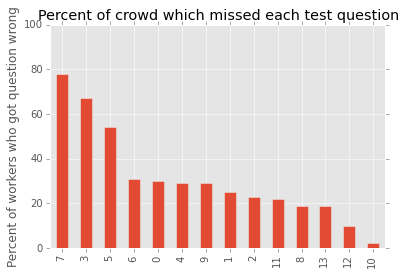

In [14]:
temp = gold_report.sort("_pct_missed", ascending = False)
graph = temp["_pct_missed"].multiply(100).plot(kind = "bar", title = "Percent of crowd which missed each test question")

graph.set_ylim((0, 100))
graph.set_ylabel("Percent of workers who got question wrong")

###Subsetting the used test questions:

In [15]:
def subset(data, include, exclude, fail_range, contest_range, max_rows = -1):
    """
    Subsets the set of previously seen test questions down.
    Ranges should be a real number from 0 to 100.
    Include and exclude should be sets.
    """
    assert isinstance(include, set)
    assert isinstance(exclude, set)
    fail_range = map(lambda x: x / 100, fail_range)
    contest_range = map(lambda x: x / 100, contest_range)
    
    keep = data.query("_id in {0}".format(list(include)))
    
    sub = data.query("_id not in {0}".format(list(include | exclude))) # don't sample includes twice
    sub = sub.query("{0} <= _pct_missed <= {1}".format(fail_range[0], fail_range[1]))
    sub = sub.query("{0} <= _pct_contested <= {1}".format(contest_range[0], contest_range[1]))
    
    # randomly sample if number of rows is too big
    if max_rows != -1 and len(keep) + len(sub) > max_rows:
        # this resets the random seed!
        sub = sub.sample(max_rows - len(keep), random_state = NUMPY_RAND_SEED)
        
    return pd.concat([keep, sub])

In [16]:
used_gold = subset(gold_report, set(), {756407881}, (0, 35), (0, 100))

In [17]:
used_gold.shape

(10, 22)

In [18]:
used_gold = used_gold[["_id", "verify_relationship_gold", "verify_relationship_gold_reason", "disease_id",
                      "disease_name", "drug_id", "drug_name", "form_abstract", "form_title", "pmid", "uniq_id"]]

In [19]:
used_gold = used_gold.rename(columns = {"_id": "old_cf_work_unit_id",
                                        "drug_id": "chemical_id", "drug_name": "chemical_name"})

In [20]:
def renamer(uniq_id):
    return "{0}_job_754530_testq".format(uniq_id)
    
used_gold["original_job_id"] = 754530
used_gold.loc[:, "uniq_id"] = used_gold.loc[:, "uniq_id"].map(renamer)

In [21]:
used_gold.head()

,old_cf_work_unit_id,verify_relationship_gold,verify_relationship_gold_reason,disease_id,disease_name,chemical_id,chemical_name,form_abstract,form_title,pmid,uniq_id,original_job_id
0,756391641,no_relation,The scientists investigated how genetics contr...,D014202,"<span class=""disease"">tremor</span>",D011188,"<span class=""chemical"">potassium</span>",<p>BACKGROUND: The septo-hippocampal cholinerg...,The relationship between hippocampal acetylcho...,12198388,bcv_hard_59_job_754530_testq,754530
1,756398159,no_relation,Women already with osteopenia were given the c...,D001851,"<span class=""disease"">osteopenia</span>",D020849,"<span class=""chemical"">raloxifene/raloxifene h...","<p>BACKGROUND: Markers of fibrinolysis, thromb...","The effects of short-term <span class=""chemica...",16167916,bcv_hard_92_job_754530_testq,754530
2,756399808,no_relation,The text doesn't say that thiazide has anythin...,D006333,"<span class=""disease"">heart failure</span>",D049971,"<span class=""chemical"">thiazide</span>",<p>BACKGROUND: A previous randomized controlle...,Spironolactone-induced renal insufficiency and...,15632880,bcv_hard_46_job_754530_testq,754530
4,756405204,yes_direct,"One subject developed ""mechanical entropion"" a...",D004774,"<span class=""disease"">entropion</span>",C016986,"<span class=""chemical"">apraclonidine/aponidine...",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,8590259,bcv_hard_54_job_754530_testq,754530
8,756408483,yes_direct,One patient developed corneal abrasion 3 hours...,D003316,"<span class=""disease"">corneal abrasion</span>",C016986,"<span class=""chemical"">apraclonidine/aponidine...",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,8590259,bcv_hard_51_job_754530_testq,754530


In [22]:
used_gold["_golden"] = "TRUE"

In [23]:
used_gold.to_csv("data/crowdflower/test_questions/abstract_test_questions.tsv", sep = '\t', index = False)

---

###Remove from real work units those which were also test questions:

In [24]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_754530_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

normal_units = filter_data(settings)
normal_ids = set(normal_units["uniq_id"].unique())

In [25]:
len(normal_ids)

97

In [26]:
normal_ids -= gold_ids
normal_units = normal_units.query("uniq_id in {0}".format(list(normal_ids)))

In [27]:
len(normal_ids)

83

###Aggregate crowd results:

In [28]:
res = aggregate_results("uniq_id", "verify_relationship", normal_units, "majority_vote", ["pmid", "_unit_id", "drug_id", "disease_id"])

In [29]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591,C063968,D017180
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,C056507,D013921
0,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,C056507,D003643
1,bcv_hard_11,no_relation,0.7857,1,0.180554,11135224,756359602,C056507,D003643
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,C056507,D009503


###Read the BioCreative gold standard:

In [30]:
if os.path.exists("data/training/parsed_training_set.pickle"):
    print "Reading cached version of training set"
    with open("data/training/parsed_training_set.pickle", "rb") as fin:
        training_data = pickle.load(fin)
else:
    training_data = parse_input("data/training", "CDR_TrainingSet.txt")
    with open("data/training/parsed_training_set.pickle", "wb") as fout:
        pickle.dump(training_data, fout)

Reading cached version of training set


In [31]:
random.seed("2015-06-11:14:46")

TESTSET_SIZE = 30
testset = random.sample(training_data, TESTSET_SIZE)

def make_dict(testset):
    return {paper.pmid : paper for paper in testset}

testset = make_dict(testset)
sorted(testset.keys())

[1130930,
 1378968,
 1835291,
 2096243,
 2265898,
 2375138,
 2515254,
 3800626,
 6666578,
 6692345,
 7449470,
 7582165,
 8590259,
 8595686,
 9522143,
 10520387,
 10835440,
 11135224,
 11569530,
 12041669,
 12198388,
 15602202,
 15632880,
 16167916,
 16337777,
 17241784,
 17261653,
 17931375,
 18631865,
 19269743]

###Determine relation pair and whether relation is in gold standard:

In [32]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591,C063968,D017180
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,C056507,D013921
0,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,C056507,D003643
1,bcv_hard_11,no_relation,0.7857,1,0.180554,11135224,756359602,C056507,D003643
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,C056507,D009503


In [33]:
def in_gold(row):
    pmid = int(row["pmid"])
    return int(testset[pmid].has_relation(Relation(pmid, row["drug_id"], row["disease_id"])))

res.loc[:, "in_gold"] = res.loc[:, ["pmid", "drug_id", "disease_id"]].apply(in_gold, axis = 1)

In [34]:
res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id,in_gold
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591,C063968,D017180,0
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,C056507,D013921,1
0,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,C056507,D003643,0
1,bcv_hard_11,no_relation,0.7857,1,0.180554,11135224,756359602,C056507,D003643,0
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,C056507,D009503,1


###Select the non-ambiguous questions:

In [35]:
good_work = res.query("num_votes >= {0}".format(4))

In [36]:
good_work["response"] = good_work.loc[:, "verify_relationship"].map(lambda x: int(x == "yes_direct"))

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
good_work.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id,in_gold,response
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591,C063968,D017180,0,0
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,C056507,D013921,1,1
0,bcv_hard_11,yes_direct,3.5659,4,0.819446,11135224,756359602,C056507,D003643,0,1
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,C056507,D009503,1,1
0,bcv_hard_14,no_relation,4.2463,5,1.000000,1378968,756359605,D003404,D011507,0,0


In [38]:
matches_gold_std = good_work.query("in_gold == response")

In [39]:
matches_gold_std["in_gold"].value_counts()

0    43
1    13
dtype: int64

In [40]:
matches_gold_std.shape

(56, 11)

In [41]:
matches_gold_std

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id,in_gold,response
0,bcv_hard_0,no_relation,4.4019,5,1.000000,11569530,756359591,C063968,D017180,0,0
0,bcv_hard_10,yes_direct,4.4417,5,1.000000,11135224,756359601,C056507,D013921,1,1
0,bcv_hard_12,yes_direct,3.3773,4,0.784342,11135224,756359603,C056507,D009503,1,1
0,bcv_hard_14,no_relation,4.2463,5,1.000000,1378968,756359605,D003404,D011507,0,0
1,bcv_hard_15,no_relation,3.5237,4,0.804351,1378968,756359606,D003404,D007674,0,0
0,bcv_hard_16,no_relation,4.5317,5,1.000000,1378968,756359607,D003404,D007676,0,0
0,bcv_hard_17,no_relation,4.4999,5,1.000000,1378968,756359608,D003404,D005921,0,0
1,bcv_hard_22,no_relation,3.4945,4,0.803038,16337777,756359613,D010862,D003643,0,0
1,bcv_hard_23,no_relation,3.5179,4,0.778658,16337777,756359614,D010862,D028361,0,0
1,bcv_hard_25,yes_direct,3.7088,4,0.826639,3800626,756359616,D010423,D009408|D020425,1,1


In [42]:
num_true_to_take = 13
num_false_to_take = 15

true_units = matches_gold_std.query("in_gold == 1")
false_units = matches_gold_std.query("in_gold == 0")

true_units = true_units.sample(num_true_to_take, random_state = NUMPY_RAND_SEED)
false_units = false_units.sample(num_false_to_take, random_state = NUMPY_RAND_SEED)

sampling = pd.concat([true_units, false_units])

In [43]:
sampling.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id,in_gold,response
0,bcv_hard_72,yes_direct,4.5179,5,1.000000,7449470,756359663,D004317,D009202,1,1
0,bcv_hard_67,yes_direct,4.3531,5,1.000000,7582165,756359658,D003907,D014581,1,1
0,bcv_hard_66,yes_direct,3.4726,4,0.789999,7582165,756359657,D003907,D003231,1,1
0,bcv_hard_4,yes_direct,4.2941,5,1.000000,11135224,756359595,D017239,D013921,1,1
0,bcv_hard_52,yes_direct,3.3992,4,0.798628,8590259,756359643,C016986,D003229,1,1


In [44]:
sampling["in_gold"].value_counts()

0    15
1    13
dtype: int64

In [45]:
q = map(int, list(sampling["unit_id"].unique()))

In [46]:
q

[756359663,
 756359658,
 756359657,
 756359595,
 756359643,
 756359624,
 756359616,
 756359601,
 756359641,
 756359629,
 756359603,
 756359655,
 756359598,
 756359646,
 756359623,
 756359649,
 756359638,
 756359605,
 756359684,
 756359648,
 756359676,
 756359665,
 756359652,
 756359606,
 756359639,
 756359607,
 756359614,
 756359636]

In [47]:
for unit in q:
    f = "[{0}](https://crowdflower.com/jobs/754530/units/{0})<br>".format(unit)
    print f

[756359663](https://crowdflower.com/jobs/754530/units/756359663)<br>
[756359658](https://crowdflower.com/jobs/754530/units/756359658)<br>
[756359657](https://crowdflower.com/jobs/754530/units/756359657)<br>
[756359595](https://crowdflower.com/jobs/754530/units/756359595)<br>
[756359643](https://crowdflower.com/jobs/754530/units/756359643)<br>
[756359624](https://crowdflower.com/jobs/754530/units/756359624)<br>
[756359616](https://crowdflower.com/jobs/754530/units/756359616)<br>
[756359601](https://crowdflower.com/jobs/754530/units/756359601)<br>
[756359641](https://crowdflower.com/jobs/754530/units/756359641)<br>
[756359629](https://crowdflower.com/jobs/754530/units/756359629)<br>
[756359603](https://crowdflower.com/jobs/754530/units/756359603)<br>
[756359655](https://crowdflower.com/jobs/754530/units/756359655)<br>
[756359598](https://crowdflower.com/jobs/754530/units/756359598)<br>
[756359646](https://crowdflower.com/jobs/754530/units/756359646)<br>
[756359623](https://crowdflower.co

[756359663](https://crowdflower.com/jobs/754530/units/756359663)<br>
[756359658](https://crowdflower.com/jobs/754530/units/756359658)<br>
[756359657](https://crowdflower.com/jobs/754530/units/756359657)<br>
[756359595](https://crowdflower.com/jobs/754530/units/756359595)<br>
[756359643](https://crowdflower.com/jobs/754530/units/756359643)<br>
[756359624](https://crowdflower.com/jobs/754530/units/756359624)<br>
[756359616](https://crowdflower.com/jobs/754530/units/756359616)<br>
[756359601](https://crowdflower.com/jobs/754530/units/756359601)<br>
[756359641](https://crowdflower.com/jobs/754530/units/756359641)<br>
[756359629](https://crowdflower.com/jobs/754530/units/756359629)<br>
[756359603](https://crowdflower.com/jobs/754530/units/756359603)<br>
[756359655](https://crowdflower.com/jobs/754530/units/756359655)<br>
[756359598](https://crowdflower.com/jobs/754530/units/756359598)<br>
[756359646](https://crowdflower.com/jobs/754530/units/756359646)<br>
[756359623](https://crowdflower.com/jobs/754530/units/756359623)<br>
[756359649](https://crowdflower.com/jobs/754530/units/756359649)<br>
[756359638](https://crowdflower.com/jobs/754530/units/756359638)<br>
[756359605](https://crowdflower.com/jobs/754530/units/756359605)<br>
[756359684](https://crowdflower.com/jobs/754530/units/756359684)<br>
[756359648](https://crowdflower.com/jobs/754530/units/756359648)<br>
[756359676](https://crowdflower.com/jobs/754530/units/756359676)<br>
[756359665](https://crowdflower.com/jobs/754530/units/756359665)<br>
[756359652](https://crowdflower.com/jobs/754530/units/756359652)<br>
[756359606](https://crowdflower.com/jobs/754530/units/756359606)<br>
[756359639](https://crowdflower.com/jobs/754530/units/756359639)<br>
[756359607](https://crowdflower.com/jobs/754530/units/756359607)<br>
[756359614](https://crowdflower.com/jobs/754530/units/756359614)<br>
[756359636](https://crowdflower.com/jobs/754530/units/756359636)<br>

exclude: 756359624 

756359616

756359629

In [48]:
sampling.shape

(28, 11)

In [49]:
sampling = sampling.query("unit_id not in {0}".format([756359624, 756359616, 756359629]))

In [50]:
sampling.shape

(25, 11)

In [51]:
sampling["verify_relationship"].value_counts()

no_relation    15
yes_direct     10
dtype: int64

In [52]:
sampling.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,drug_id,disease_id,in_gold,response
0,bcv_hard_72,yes_direct,4.5179,5,1.000000,7449470,756359663,D004317,D009202,1,1
0,bcv_hard_67,yes_direct,4.3531,5,1.000000,7582165,756359658,D003907,D014581,1,1
0,bcv_hard_66,yes_direct,3.4726,4,0.789999,7582165,756359657,D003907,D003231,1,1
0,bcv_hard_4,yes_direct,4.2941,5,1.000000,11135224,756359595,D017239,D013921,1,1
0,bcv_hard_52,yes_direct,3.3992,4,0.798628,8590259,756359643,C016986,D003229,1,1


---

In [53]:
work_tests = defaultdict(list)

for idx, row in sampling.iterrows():
    pmid = int(row["pmid"])
    unit_id = row["unit_id"]
    
    raw_info = normal_units.query("_unit_id == {0}".format(unit_id))
    raw_info = raw_info.iloc[0]
    
    
    
    
    work_tests["pmid"].append(pmid)
    work_tests["verify_relationship_gold"].append(row["verify_relationship"])
    work_tests["verify_relationship_gold_reason"].append("")
    work_tests["old_cf_work_unit_id"].append(unit_id)
    work_tests["disease_id"].append(raw_info["disease_id"])
    work_tests["disease_name"].append(raw_info["disease_name"])
    
    work_tests["chemical_id"].append(raw_info["drug_id"])
    work_tests["chemical_name"].append(raw_info["drug_name"])
    work_tests["form_abstract"].append(raw_info["form_abstract"])
    work_tests["form_title"].append(raw_info["form_title"])
    work_tests["uniq_id"].append("{0}_job_754530_regular_work".format(row["uniq_id"]))
    work_tests["original_job_id"].append("754530")
    work_tests["_golden"].append("TRUE")
    
work_tests = pd.DataFrame(work_tests)
    
    

In [54]:
work_tests.head()

,_golden,chemical_id,chemical_name,disease_id,disease_name,form_abstract,form_title,old_cf_work_unit_id,original_job_id,pmid,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
0,TRUE,D004317,"<span class=""chemical"">doxorubicin/adriamycin<...",D009202,"<span class=""disease"">Cardiomyopathy</span>",Cardiac toxicity is a major complication which...,"Late, late <span class=""chemical"">doxorubicin<...",756359663,754530,7449470,bcv_hard_72_job_754530_regular_work,yes_direct,
1,TRUE,D003907,"<span class=""chemical"">dexamethasone</span>",D014581,"<span class=""disease"">urticaria</span>",Two patients treated with parenteral parametha...,Pseudo-allergic reactions to corticosteroids: ...,756359658,754530,7582165,bcv_hard_67_job_754530_regular_work,yes_direct,
2,TRUE,D003907,"<span class=""chemical"">dexamethasone</span>",D003231,"<span class=""disease"">conjunctivitis</span>",Two patients treated with parenteral parametha...,Pseudo-allergic reactions to corticosteroids: ...,756359657,754530,7582165,bcv_hard_66_job_754530_regular_work,yes_direct,
3,TRUE,D017239,"<span class=""chemical"">Paclitaxel</span>",D013921,"<span class=""disease"">thrombocytopenia</span>",<p>BACKGROUND: Cisplatin-based chemotherapy co...,"<span class=""chemical"">Paclitaxel</span>, cisp...",756359595,754530,11135224,bcv_hard_4_job_754530_regular_work,yes_direct,
4,TRUE,C016986,"<span class=""chemical"">apraclonidine/aponidine...",D003229,"<span class=""disease"">Conjunctival blanching</...",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,756359643,754530,8590259,bcv_hard_52_job_754530_regular_work,yes_direct,


---

In [55]:
job_758429_gold = pd.read_csv("data/crowdflower/gold_reports/job_758429_gold_report.csv", sep = ',')

In [56]:
job_758429_gold.head()

,_id,_pct_missed,_judgments,_hidden,_contention,_pct_contested,_gold_pool,_verify_relationship,verify_relationship_gold,verify_relationship_gold_reason,...,chemical_name,disease_id,disease_name,form_abstract,form_title,old_cf_work_unit_id,original_job_id,pmid,uniq_id,comment_box_gold_reason
0,765516969,0,0,False,NaN,0,NaN,NaN,no_relation,The scientists investigated how genetics contr...,...,"<span class=""chemical"">potassium</span>",D014202,"<span class=""disease"">tremor</span>",<p>BACKGROUND: The septo-hippocampal cholinerg...,The relationship between hippocampal acetylcho...,756391641,754530,12198388,bcv_hard_59_job_754530_testq,NaN
1,765516970,0,0,False,NaN,0,NaN,NaN,no_relation,Women already with osteopenia were given the c...,...,"<span class=""chemical"">raloxifene/raloxifene h...",D001851,"<span class=""disease"">osteopenia</span>","<p>BACKGROUND: Markers of fibrinolysis, thromb...","The effects of short-term <span class=""chemica...",756398159,754530,16167916,bcv_hard_92_job_754530_testq,NaN
2,765516971,0,0,False,NaN,0,NaN,NaN,no_relation,The text doesn't say that thiazide has anythin...,...,"<span class=""chemical"">thiazide</span>",D006333,"<span class=""disease"">heart failure</span>",<p>BACKGROUND: A previous randomized controlle...,Spironolactone-induced renal insufficiency and...,756399808,754530,15632880,bcv_hard_46_job_754530_testq,NaN
3,765516972,0,0,False,NaN,0,NaN,NaN,yes_direct,"One subject developed ""mechanical entropion"" a...",...,"<span class=""chemical"">apraclonidine/aponidine...",D004774,"<span class=""disease"">entropion</span>",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,756405204,754530,8590259,bcv_hard_54_job_754530_testq,NaN
4,765516973,0,0,False,NaN,0,NaN,NaN,yes_direct,One patient developed corneal abrasion 3 hours...,...,"<span class=""chemical"">apraclonidine/aponidine...",D003316,"<span class=""disease"">corneal abrasion</span>",We prospectively evaluated the adverse reactio...,Evaluation of adverse reactions of <span class...,756408483,754530,8590259,bcv_hard_51_job_754530_testq,NaN


In [57]:
used_gold["uniq_id"]

0     bcv_hard_59_job_754530_testq
1     bcv_hard_92_job_754530_testq
2     bcv_hard_46_job_754530_testq
4     bcv_hard_54_job_754530_testq
8     bcv_hard_51_job_754530_testq
9     bcv_hard_31_job_754530_testq
10    bcv_hard_73_job_754530_testq
11    bcv_hard_63_job_754530_testq
12    bcv_hard_36_job_754530_testq
13    bcv_hard_13_job_754530_testq
Name: uniq_id, dtype: object

In [58]:
job_758429_gold["uniq_id"]

0     bcv_hard_59_job_754530_testq
1     bcv_hard_92_job_754530_testq
2     bcv_hard_46_job_754530_testq
3     bcv_hard_54_job_754530_testq
4     bcv_hard_51_job_754530_testq
5     bcv_hard_31_job_754530_testq
6     bcv_hard_73_job_754530_testq
7     bcv_hard_63_job_754530_testq
8     bcv_hard_36_job_754530_testq
9     bcv_hard_13_job_754530_testq
10                    bcv_hard_223
11                    bcv_hard_609
12                    bcv_hard_113
13                     bcv_hard_32
14                    bcv_hard_180
15                    bcv_hard_162
16                    bcv_hard_401
17                    bcv_hard_712
18                    bcv_hard_887
19                    bcv_hard_390
20                    bcv_hard_206
21                      bcv_hard_9
22                    bcv_hard_324
23                   bcv_hard_1092
24                    bcv_hard_439
25                   bcv_hard_1163
26                    bcv_hard_595
Name: uniq_id, dtype: object

In [59]:
a = set(used_gold["uniq_id"])

In [60]:
b = set(job_758429_gold["uniq_id"])

In [61]:
job_758429_gold = job_758429_gold.query("uniq_id not in {0}".format(list(a)))

In [62]:
job_758429_gold.shape

(17, 22)

In [63]:
list(job_758429_gold.columns.values)

['_id',
 '_pct_missed',
 '_judgments',
 '_hidden',
 '_contention',
 '_pct_contested',
 '_gold_pool',
 '_verify_relationship',
 'verify_relationship_gold',
 'verify_relationship_gold_reason',
 '_golden',
 'chemical_id',
 'chemical_name',
 'disease_id',
 'disease_name',
 'form_abstract',
 'form_title',
 'old_cf_work_unit_id',
 'original_job_id',
 'pmid',
 'uniq_id',
 'comment_box_gold_reason']

In [64]:
job_758429_gold = job_758429_gold[["_id", "verify_relationship_gold", "verify_relationship_gold_reason", "disease_id",
                      "disease_name", "chemical_id", "chemical_name", "form_abstract", "form_title", "pmid", "uniq_id"]]

In [65]:
job_758429_gold = job_758429_gold.rename(columns = {"_id": "old_cf_work_unit_id"})

In [66]:
job_758429_gold["original_job_id"] = 758429

In [67]:
list(job_758429_gold.columns.values)

['old_cf_work_unit_id',
 'verify_relationship_gold',
 'verify_relationship_gold_reason',
 'disease_id',
 'disease_name',
 'chemical_id',
 'chemical_name',
 'form_abstract',
 'form_title',
 'pmid',
 'uniq_id',
 'original_job_id']

In [68]:
job_758429_gold["uniq_id"]

10     bcv_hard_223
11     bcv_hard_609
12     bcv_hard_113
13      bcv_hard_32
14     bcv_hard_180
15     bcv_hard_162
16     bcv_hard_401
17     bcv_hard_712
18     bcv_hard_887
19     bcv_hard_390
20     bcv_hard_206
21       bcv_hard_9
22     bcv_hard_324
23    bcv_hard_1092
24     bcv_hard_439
25    bcv_hard_1163
26     bcv_hard_595
Name: uniq_id, dtype: object

In [69]:
job_758429_gold.head()

,old_cf_work_unit_id,verify_relationship_gold,verify_relationship_gold_reason,disease_id,disease_name,chemical_id,chemical_name,form_abstract,form_title,pmid,uniq_id,original_job_id
10,765520391,no_relation,The last sentence of the background says the a...,C562477,"<span class=""disease"">halothane hepatitis</span>",C067411|C072959,"<span class=""chemical"">HCFCs 123 and 124</span>",<p>BACKGROUND: Hydrochlorofluorocarbons (HCFCs...,Epidemic of liver disease caused by hydrochlor...,9284778,bcv_hard_223,758429
11,765520612,no_relation,"Ten cancer patients were given ""ketamine"" to s...",D006212,"<span class=""disease"">Hallucinations</span>",D003975,"<span class=""chemical"">diazepam</span>",Pain not responsive to morphine is often probl...,Analgesic effect of intravenous ketamine in ca...,11027905,bcv_hard_609,758429
12,765520740,no_relation,No mention of whether bilirubin and meningeal ...,D008577,"<span class=""disease"">meningeal leukemia</span>",D001663,"<span class=""chemical"">bilirubin</span>",Twenty children with acute lymphoblastic leuke...,"Remission induction of <span class=""disease"">m...",3856631,bcv_hard_113,758429
13,765520920,no_relation,The boy developed some complications after rec...,D007239,"<span class=""disease"">infections</span>",D005839,"<span class=""chemical"">gentamicin</span>",<p>OBJECTIVE: To report a case of erythema mul...,Erythema multiforme and hypersensitivity myoca...,7919560,bcv_hard_32,758429
14,765520980,no_relation,Atropine application increased blood flow to t...,D003027,"<span class=""disease"">cluster headache</span>",D001285,"<span class=""chemical"">atropine</span>","<span class=""disease"">Cluster headache</span> ...",Noxious chemical stimulation of rat facial muc...,15009014,bcv_hard_180,758429


In [70]:
job_758429_gold.head()

,old_cf_work_unit_id,verify_relationship_gold,verify_relationship_gold_reason,disease_id,disease_name,chemical_id,chemical_name,form_abstract,form_title,pmid,uniq_id,original_job_id
10,765520391,no_relation,The last sentence of the background says the a...,C562477,"<span class=""disease"">halothane hepatitis</span>",C067411|C072959,"<span class=""chemical"">HCFCs 123 and 124</span>",<p>BACKGROUND: Hydrochlorofluorocarbons (HCFCs...,Epidemic of liver disease caused by hydrochlor...,9284778,bcv_hard_223,758429
11,765520612,no_relation,"Ten cancer patients were given ""ketamine"" to s...",D006212,"<span class=""disease"">Hallucinations</span>",D003975,"<span class=""chemical"">diazepam</span>",Pain not responsive to morphine is often probl...,Analgesic effect of intravenous ketamine in ca...,11027905,bcv_hard_609,758429
12,765520740,no_relation,No mention of whether bilirubin and meningeal ...,D008577,"<span class=""disease"">meningeal leukemia</span>",D001663,"<span class=""chemical"">bilirubin</span>",Twenty children with acute lymphoblastic leuke...,"Remission induction of <span class=""disease"">m...",3856631,bcv_hard_113,758429
13,765520920,no_relation,The boy developed some complications after rec...,D007239,"<span class=""disease"">infections</span>",D005839,"<span class=""chemical"">gentamicin</span>",<p>OBJECTIVE: To report a case of erythema mul...,Erythema multiforme and hypersensitivity myoca...,7919560,bcv_hard_32,758429
14,765520980,no_relation,Atropine application increased blood flow to t...,D003027,"<span class=""disease"">cluster headache</span>",D001285,"<span class=""chemical"">atropine</span>","<span class=""disease"">Cluster headache</span> ...",Noxious chemical stimulation of rat facial muc...,15009014,bcv_hard_180,758429


In [71]:
def rofl(a):
    return "{0}_job_758429_hand_test_questions".format(a) 

job_758429_gold.loc[:, "uniq_id"] = job_758429_gold["uniq_id"].map(rofl)

In [72]:
job_758429_gold["_golden"] = "TRUE"

---

In [73]:
final_test_ques = pd.concat([used_gold, job_758429_gold, work_tests])

In [74]:
final_test_ques.to_csv("data/crowdflower/test_questions/final_abstract_test_questions.tsv", sep = "\t", index = False)